In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{max-width:80%!important;width:auto!important;}</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from tqdm.notebook import trange, tqdm

import cv2
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
colour = Path('../GTA_images/Simple/Colour')
depth = Path('../GTA_images/Simple/Depth')

import sys
sys.path.append('../')

from depth_Functions import (
    import_raw_colour_image, 
    import_raw_depth_image, 
    show_img,
    show_array_of_images,
    show_function
)

from Feature_Extraction import (
    get_feature_vector,
    get_squared_features,
    get_features_with_squares
)

from Feature_Patches import Patches

from Laplacian import Laplacian

ImportError: cannot import name 'get_feature_vector' from 'Feature_Extraction' (/storage/depth_estimation/Markov_Random_Field/Feature_Extraction.py)

In [ ]:
colour_images = [import_raw_colour_image(str(file)) for file in sorted(colour.iterdir())]
depth_images = [import_raw_depth_image(str(file)) for file in sorted(depth.iterdir())]

In [4]:
train_images = colour_images[:-1]
train_labels = depth_images[:-1]
test_images = colour_images[-1]
test_labels = depth_images[-1]

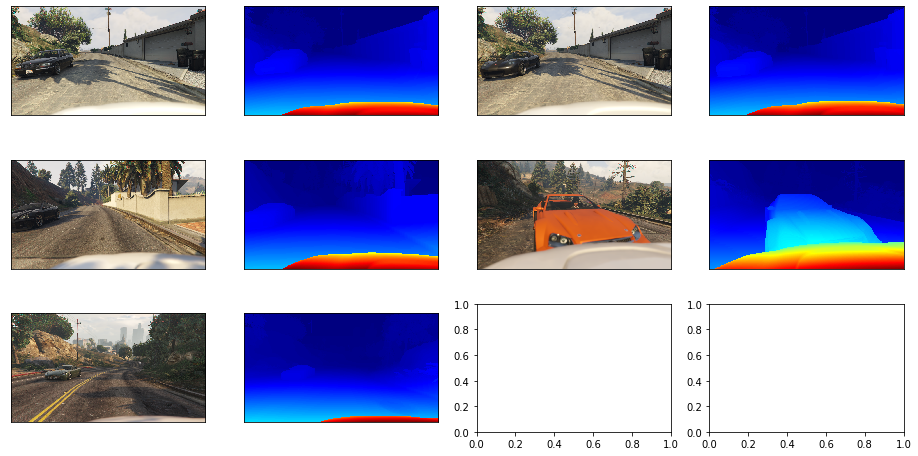

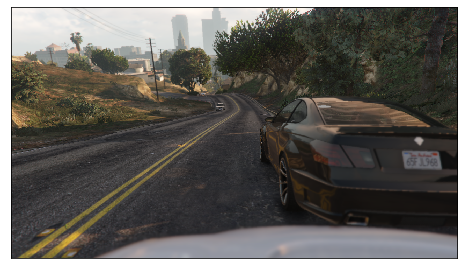

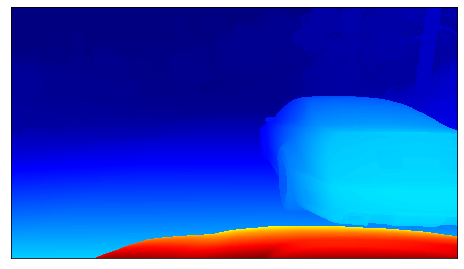

In [5]:
show_array_of_images([x for y in zip(train_images, train_labels) for x in y], image_array_shape=(3,4), figsize=(8,16), depthmap=True)
show_array_of_images([test_images, test_labels], figsize=(8,16), depthmap=True)

In [6]:
show_function(Laplacian.__init__)

def __init__(self, initial_weights, local_function, z=1, global_function=None, patchshapes=None):
        #For weights of higher than 1D we require the additional dimension of size 1
        self.z = z
        self.weights = np.array(initial_weights) #.reshape((*initial_weights.shape,1))
        self.var_weights = self.weights
        self.covariance = np.zeros((*initial_weights.shape[:-1],initial_weights.shape[-1], initial_weights.shape[-1]))
        self.local_function = local_function
        self.global_function = global_function
        self.patchshapes = patchshapes

In [58]:
show_function(Laplacian.train)

def train(self, train_images, train_labels):
        for image, labels in tqdm(zip(train_images, train_labels), total=len(train_images), leave=False):
            patch = self.create_patch(image)
            self.fit(patch.get_features(), labels)

# Filtering the whole image vs Filtering in patches

In [ ]:
whole_patch_weights = np.array([1e-2 for i in range(34)])
whole = Laplasian(whole_patch_weights, get_features_with_squares)
patch = Laplasian(whole_patch_weights, get_features_with_squares)

patch.train(train_images, train_labels, patchsize=(6,8))
whole.train(train_images, train_labels)

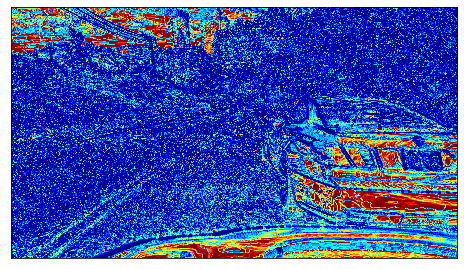

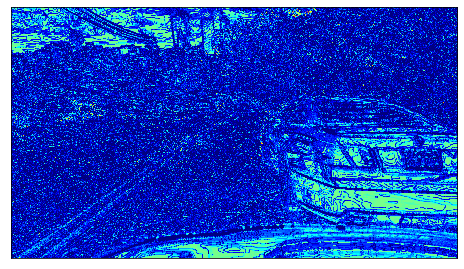

In [81]:
show_img(whole.predict(test_images), depthmap=True)

show_img(patch.predict(test_images), depthmap=True)

# Testing Columns, Rows and using squared values

In [7]:
functions = 2*[get_feature_vector, get_squared_features, get_features_with_squares]
weights = [np.zeros((17)), np.zeros((17)), np.zeros((34)), np.zeros((720,17)), np.zeros((720,17)), np.zeros((720,34))]
weights = [w+1e-3 for w in weights]

In [8]:
[w.shape for w in weights]

[(17,), (17,), (34,), (720, 17), (720, 17), (720, 34)]

In [82]:
from tqdm.notebook import tqdm

experiments = []

for weight, function in tqdm(zip(weights, functions), total=len(weights), leave=False):
    experiments.append(Laplacian(weight, function))
    experiments[-1].train(train_images, train_labels)

TypeError: zip argument #2 must support iteration

In [257]:
predictions = []
for exp in tqdm(experiments):
    predictions.append(exp.predict(test_images))

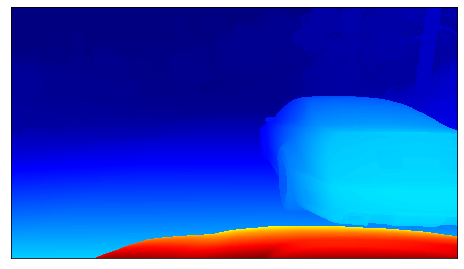

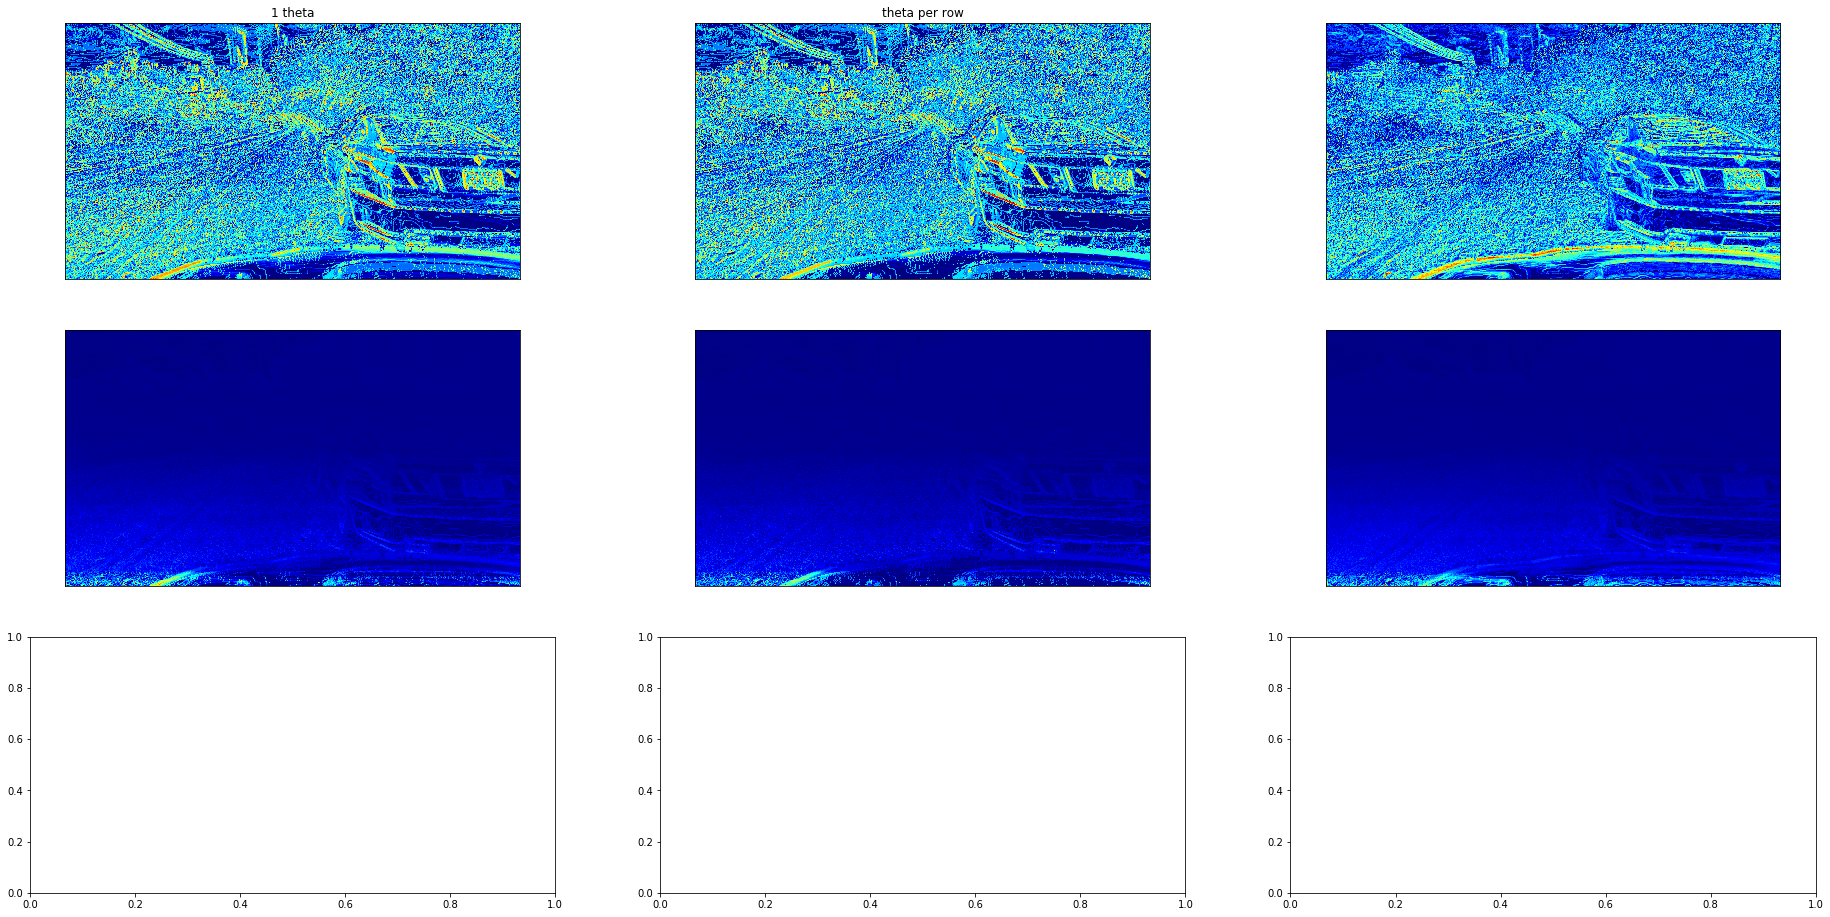

In [258]:
show_img(depth_images[-1], depthmap=True)
show_array_of_images(predictions, depthmap=True, figsize=(16,32), titles=['1 theta', 'theta per row'])

In [143]:
for i, (function, weight) in tqdm(enumerate(zip(functions, weights)), total=len(functions)):
    experiments[i].train(train_images, train_labels)
    predictions.append(experiments[i].predict(test_images))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 18 is different from 17)

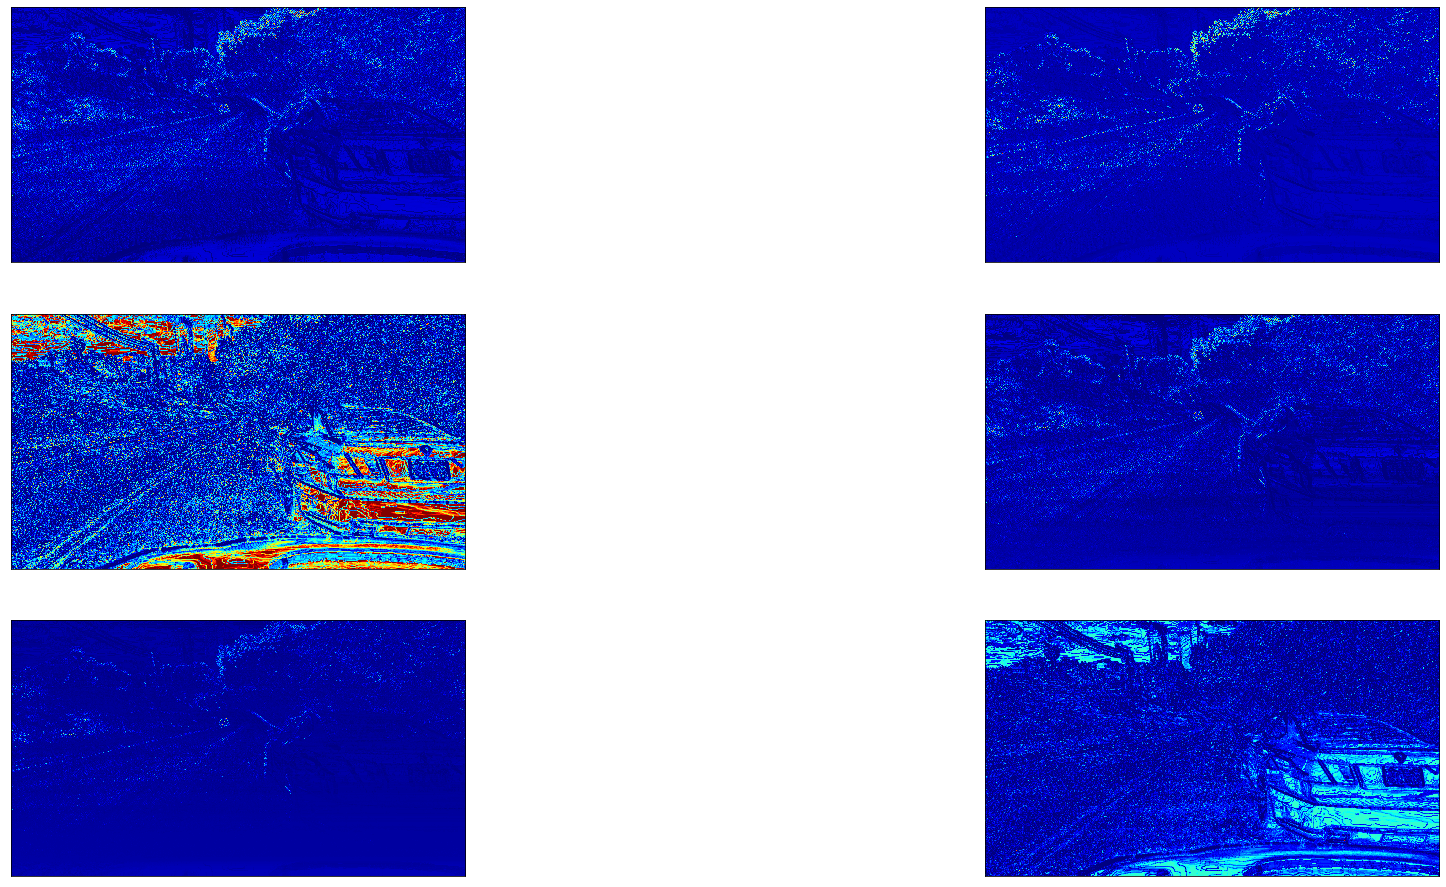

In [239]:
show_array_of_images(predictions[6:], depthmap=True, image_array_shape=(3,2), figsize=(16,32))

**It doesn't appear that repeating the training has noticable improvements, at least for this sample size**

In [129]:
depth_images[-1][0][0]

1.0

In [132]:
predictions[-1][0][0]

array([0.])

# Laplasian

In [31]:
least_squares = Laplasian(np.array([[1e-2 for i in range(17)]for i in range(720)]), local_function=get_feature_vector)
laplacian = Laplasian(np.array([[1e-2 for i in range(17)]for i in range(720)]), local_function=get_feature_vector)

In [32]:
least_squares.weights.shape

(720, 17)

In [34]:
laplacian.weights.shape

(720, 17)

In [36]:
least_squares.train('least_squares_function', train_images, train_labels)
laplacian.train('laplasian_function', train_images, train_labels)

/storage/depth_estimation/Markov_Random_Field/Laplasian.py:68: RuntimeWarning: overflow encountered in exp
  return np.exp(-features @ weights)


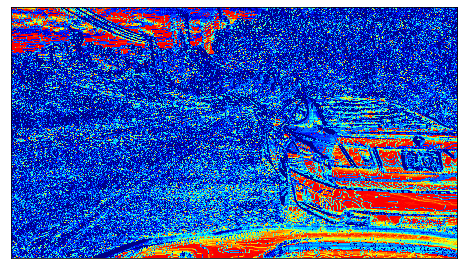

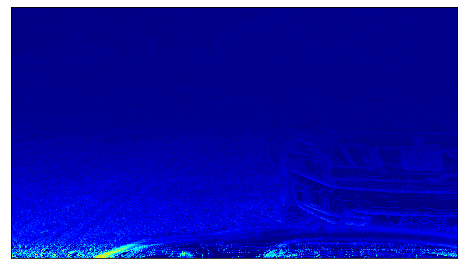

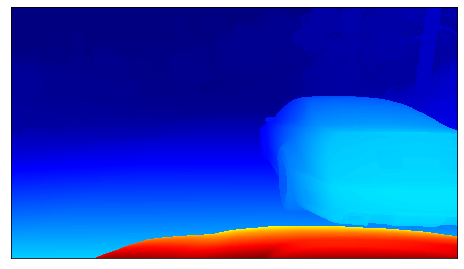

In [41]:
show_img(least_squares.predict('least_squares_function',test_images), depthmap=True)
show_img(laplacian.predict('laplasian_function',test_images), depthmap=True)
show_img(test_labels, depthmap=True)

# Features vs Depths

In [182]:
functions = 3*[get_feature_vector, get_squared_features, get_features_with_squares]
weights = [np.ones((17)), np.ones((17)), np.ones((34)), np.ones((1280,17)), np.ones((1280,17)), np.ones((1280,34)), np.ones((720,17)), np.ones((720,17)), np.ones((720,34))]

In [193]:
x_data = [Laplasian(weight, function) for (weight, function) in zip(weights, functions)]

In [194]:
x_data[0].weights.shape

(17,)

In [ ]:
_, axis = plt.subplots(3,3,figsize=(16,8))

for i, x in enumerate(x_data):
    axis[int(i/2)][i%2].plot(x.predict(test_images), test_labels)
#     axis[int(i/2)][i%2].set_yscale('log')

pass;

In [ ]:
predictions = []
for exp in tqdm(experiments):
    predictions.append(exp.predict(test_images))